In [27]:
#!pip install pdpbox
from time import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence
path="../../data/"

In [28]:
from utils import *
from MLModels import *
from DataProcessing import *

In [29]:

config = dict(scale_pos_weight = 6,subsample = 1, min_child_weight = 5, max_depth = 5, gamma= 2, 
              colsample_bytree= 0.6,smote=1)

config_rebal = dict(scale_pos_weight = 1,subsample = 1, min_child_weight = 5, max_depth = 5, gamma= 2, 
              colsample_bytree= 0.6,smote=1)


mod_rf = RandomForestClassifier(max_depth=5, random_state=0)

svm_mod = SVC(probability=True)




In [30]:

drpvars1='AD|hospital_episode_type_f41231_General\
|spells_in_hospital_f41235|sexual_partners|using_computer|interpolated_year|\
genotype_measurement_batch_f2200|\
f21052|f2188|f20463|coeliac|Unknown|death|APOE4|consultant|f20434|year_of_birth|age|set|\
history_of_psychiatric|carer_support|sunlamp|answered_sexual|samesex|death'

drpvars1='death|AD|Unknown|answered_sexual_history_questions|speciality_of_consultant|APOE4|\
hospital_episode_type|history_of_psychiatric|samesex|year_of_birth|age|sexual_partners|using_computer|sex_inference'

drpvars_mod='AD|eid|CERVASCALL_bef|Unknown|answered_sexual_history_questions|speciality_of_consultant|APOE4|\
hospital_episode_type|history_of_psychiatric|samesex|year_of_birth|age|sexual_partners|using_computer|sex_inference'


drpvarsapoe='AD|hospital_episode_type_f41231_General\
|spells_in_hospital_f41235|sexual_partners|using_computer|interpolated_year|\
genotype_measurement_batch_f2200|\
f21052|f2188|f20463|coeliac|Unknown|death|APOE4|consultant|f20434|year_of_birth|age|set|APOE|Genotype'

drpvarsapoe='AD|Unknown|answered_sexual_history_questions|speciality_of_consultant|APOE4|\
hospital_episode_type|history_of_psychiatric|samesex|year_of_birth|Genotype|age'


drvarsdef=['DIAB','DIAB_bef','CERVASC','CERVASC_bef','PD','CERVASC','EPIL']

drpvarssurv='AD|DIAB|EPIL|CERVASC_bef|spells_in_hospital_f41235|\
hospital_episode_type_f41231_General episode|genotype_measurement_batch_f2200|consultant\
|Unknown|Not at all'

genos=[
 'Genotype_e1/e4',
 'Genotype_e2/e2',
 'Genotype_e2/e3',
 'Genotype_e2/e4',
 'Genotype_e3/e3',
 'Genotype_e3/e4',
 'Genotype_e4/e4']

genotypes=['Genotype_e1/e2',"Genotype_e2/e2","Genotype_e2/e3","Genotype_e3/e3","Genotype_e2/e4","Genotype_e1/e4",
          "Genotype_e3/e4","Genotype_e4/e4"]

gen_lkup={'Genotype_e2/e2':1,"Genotype_e1/e2":2,"Genotype_e2/e3":3,"Genotype_e3/e3":4,
          "Genotype_e2/e4":5,"Genotype_e1/e4":6,"Genotype_e3/e4":7,"Genotype_e4/e4":8}

gen_lkup_rev={1:'Genotype_e2/e2',2:"Genotype_e1/e2",3:"Genotype_e2/e3",4:"Genotype_e3/e3",
          5:"Genotype_e2/e4",6:"Genotype_e1/e4",7:"Genotype_e3/e4",8:"Genotype_e4/e4"}

def int_vars(df,var1,vars=genos):
    for var in vars:
        df[str(var1)+" "+var]=df[var]*df[var1]
    return df

def newfeats(df,shapsum,depvar='AD',feats=30):
    
    if feats==max:
        cols=[col for col in df if col in np.asarray(shapsum['column_name'])]
    
    else:
        cols=[col for col in df if col in np.asarray(shapsum.head(feats)['column_name'])]
    
    if 'eid' in cols:
        df_out=df[np.append(['AD'],cols)]   
    else:
        df_out=df[np.append(['AD','eid'],cols)]
    return df_out

def cleandf(df,alm=1):
    df=replacenullsmean(df)
    
    if alm==1:
        df['alan_aspar_rat']=round((df['aspartate_aminotransferase_f30650']\
                                          /df['alanine_aminotransferase_f30620']),1)

    #change to any of the pollution metrics in the top 40%
    
    
        df['polluted']=0
        df['polluted'][(df['particulate_matter_air_pollution_pm25_absorbance_2010_f24007']>10)]=1


    df=col_spec_chars(df)
    #df=replace_genotype(df,gen_lkup,genotypes)
    return df

def maskapoedf(df,apoe=1):
    
    if apoe==1:
        apoemask=(df['Genotype_e3/e4']==1)|(df['Genotype_e4/e4']==1)|\
        (df['Genotype_e2/e4']==1)|(df['Genotype_e1/e4']==1)
        return df[apoemask]
    
    elif apoe==0:

        non_apoemask=(df['Genotype_e2/e3']==1)|(df['Genotype_e3/e3']==1)|\
        (df['Genotype_e1/e2']==1)|(df['Genotype_e2/e2']==1)
        return df[non_apoemask]



In [ ]:
AD_model_full70=pd.read_pickle('%s%s' % (path,'AD_model_full70.p'))
AD_model_full=pd.read_pickle('%s%s' % (path,'AD_model_full.p'))
AD_model_age=pd.read_pickle('%s%s' % (path,'AD_modelage.p'))

In [18]:
AD_model_full_modify=pd.read_pickle('%s%s' % (path,'AD_model_full70_mod.p'))

In [31]:
AD_model_full70=cleandf(AD_model_full70)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [32]:
dropvars_full=varstodrop(AD_model_full70,drpvars_mod,drvarsdef)

iteration: 0


using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



iteration: 1


using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



iteration: 2


using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



iteration: 3


using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



iteration: 4


using a dict on a Series for aggregation
is deprecated and will be removed in a future version. Use                 named aggregation instead.

    >>> grouper.agg(name_1=func_1, name_2=func_2)



Accuracy : 0.9904
0.0
AUC Score (Train): 0.780974


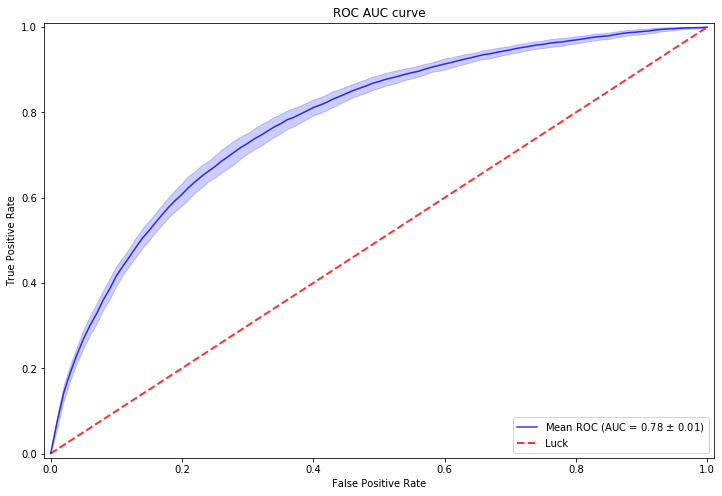

In [22]:
score_rf=newmodelrun(AD_model_full70,dropvars=dropvars_full,model=mod_rf,depvar='AD',
                    reps=5,splits=5,rebalance=0,max_display=25,plot_type="dot",shap=0)


In [ ]:
score_svc=newmodelrun(AD_model_full70,dropvars=dropvars_full,model=svm_mod,depvar='AD',
                    reps=1,splits=5,rebalance=0,max_display=25,plot_type="dot",shap=0)




iteration: 0
